<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Doubly Robust Learner and Interpretability

Double Machine Learning (DML) is an algorithm that applies arbitrary machine learning methods
to fit the treatment and response, then uses a linear model to predict the response residuals
from the treatment residuals.

To run this jupyter notebook, you need to clone and setup the EconML library version from the branch:
https://github.com/microsoft/EconML/tree/vasilis/cate_interpreters

`git clone git@github.com:microsoft/EconML.git`

`git checkout vasilis/cate_interpreters`

`python setup.py develop`

For more information on these classes you can locally build the documentation for this branch using the instructions from the README: i.e. 

`python setup.py build_sphinx -W -E -a`


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Ignore warnings
import warnings
warnings.filterwarnings('ignore') 

In [3]:
# Helper imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns

# Generating Data

In [4]:
import scipy.special

np.random.seed(123)
n=2000 # number of raw samples
d=10 # number of binary features + 1

# Generating random segments aka binary features. We will use features 0,...,3 for heterogeneity.
# The rest for controls. Just as an example.
X = np.random.binomial(1, .5, size=(n, d))
# Generating an imbalanced A/B test
T = np.random.binomial(1, scipy.special.expit(X[:, 0]))
# Generating an outcome with treatment effect heterogeneity. The first binary feature creates heterogeneity
# We also have confounding on the first variable. We also have heteroskedastic errors.
y = (-1 + 2 * X[:, 0]) * T + X[:, 0] + (1*X[:, 0] + 1)*np.random.normal(0, 1, size=(n,))

# Applying the LinearDRLearner

In [5]:
from sklearn.linear_model import LassoCV
from econml.drlearner import LinearDRLearner
from sklearn.linear_model import LogisticRegressionCV
from sklearn.dummy import DummyClassifier

# One can replace model_y and model_t with any scikit-learn regressor and classifier correspondingly
# as long as it accepts the sample_weight keyword argument at fit time.
est = LinearDRLearner(model_regression=LassoCV(cv=3),
                      model_propensity=DummyClassifier(strategy='prior'))
est.fit(y, T, X=X[:, :4], inference='statsmodels')

In [6]:
# Treatment Effect of particular segments
est.effect(np.array([[1, 0, 0, 0]])) # effect of segment with features [1, 0, 0, 0]

array([1.03520242])

In [7]:
# Confidence interval for effect. Produces the (alpha*100/2, (1-alpha)*100/2)% Confidence Interval
est.effect_interval(np.array([[1, 0, 0, 0]]), alpha=.05) # effect of segment with features [1, 0, 0, 0]

(array([0.67541139]), array([1.39499346]))

In [8]:
# Getting the coefficients of the linear CATE model together with the corresponding feature names
print(np.array(list(zip(est.cate_feature_names(['A', 'B', 'C', 'D']), est.coef_(T=1)))))
print(est.intercept_(T=1))

[['A' '2.0611395721085315']
 ['B' '-0.004465889924987199']
 ['C' '-0.13379513611508576']
 ['D' '0.0787587064190598']]
-1.0259371477652277


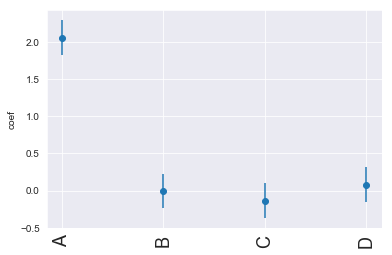

In [9]:
# Getting the confidence intervals of the coefficients of the CATE model
# together with the corresponding feature names.
feat_names = est.cate_feature_names(['A', 'B', 'C', 'D'])
point = est.coef_(T=1)
lower, upper = np.array(est.coef__interval(T=1))
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,1) 
    x = np.arange(len(point))
    plt.errorbar(x, point, yerr, fmt='o')
    ax.set_xticks(x)
    ax.set_xticklabels(feat_names, rotation='vertical', fontsize=18)
    ax.set_ylabel('coef')
    plt.show()

### Polynomial Features

In [10]:
from econml.utilities import WeightedLassoCV
from econml.drlearner import LinearDRLearner
from sklearn.linear_model import LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import PolynomialFeatures

# One can replace model_y and model_t with any scikit-learn regressor and classifier correspondingly
# as long as it accepts the sample_weight keyword argument at fit time.
est = LinearDRLearner(model_regression=WeightedLassoCV(cv=3),
                      model_propensity=DummyClassifier(strategy='prior'),
                      featurizer=PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
est.fit(y, T, X=X[:, :4], inference='statsmodels')

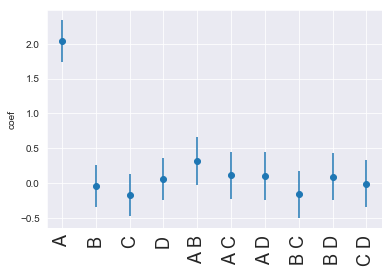

In [14]:
# Getting the confidence intervals of the coefficients of the CATE model
# together with the corresponding feature names.
feat_names = est.cate_feature_names(['A', 'B', 'C', 'D'])
point = est.coef_(T=1)
lower, upper = np.array(est.coef__interval(T=1, alpha=0.05))
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,1) 
    x = np.arange(len(point))
    plt.errorbar(x, point, yerr, fmt='o')
    ax.set_xticks(x)
    ax.set_xticklabels(feat_names, rotation='vertical', fontsize=18)
    ax.set_ylabel('coef')
    plt.show()

### Polynomial Features and Debiased Lasso Inference

In [17]:
from econml.utilities import WeightedLassoCV
from econml.drlearner import SparseLinearDRLearner
from sklearn.linear_model import LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import PolynomialFeatures

# One can replace model_y and model_t with any scikit-learn regressor and classifier correspondingly
# as long as it accepts the sample_weight keyword argument at fit time.
est = SparseLinearDRLearner(model_regression=WeightedLassoCV(cv=3),
                      model_propensity=DummyClassifier(strategy='prior'),
                      featurizer=PolynomialFeatures(degree=3, interaction_only=True, include_bias=False))
est.fit(y, T, X=X[:, :4], inference='debiasedlasso')

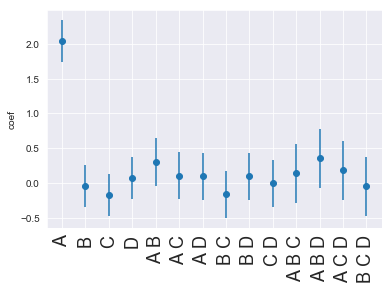

In [18]:
# Getting the confidence intervals of the coefficients of the CATE model
# together with the corresponding feature names.
feat_names = est.cate_feature_names(['A', 'B', 'C', 'D'])
point = est.coef_(T=1)
lower, upper = np.array(est.coef__interval(T=1, alpha=0.05))
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,1) 
    x = np.arange(len(point))
    plt.errorbar(x, point, yerr, fmt='o')
    ax.set_xticks(x)
    ax.set_xticklabels(feat_names, rotation='vertical', fontsize=18)
    ax.set_ylabel('coef')
    plt.show()

# Tree Interpretation of the CATE Model

In [19]:
from econml.cate_interpreter import SingleTreeCateInterpreter

In [20]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
# We interpret the CATE models behavior on the distribution of heterogeneity features
intrp.interpret(est, X[:, :4])

In [21]:
# exporting to a dot file
intrp.export_graphviz(out_file='cate_tree.dot', feature_names=['A', 'B', 'C', 'D'])

In [22]:
# or we can directly render. Requires the graphviz python library
intrp.render(out_file='dr_cate_tree', format='pdf', view=True, feature_names=['A', 'B', 'C', 'D'])

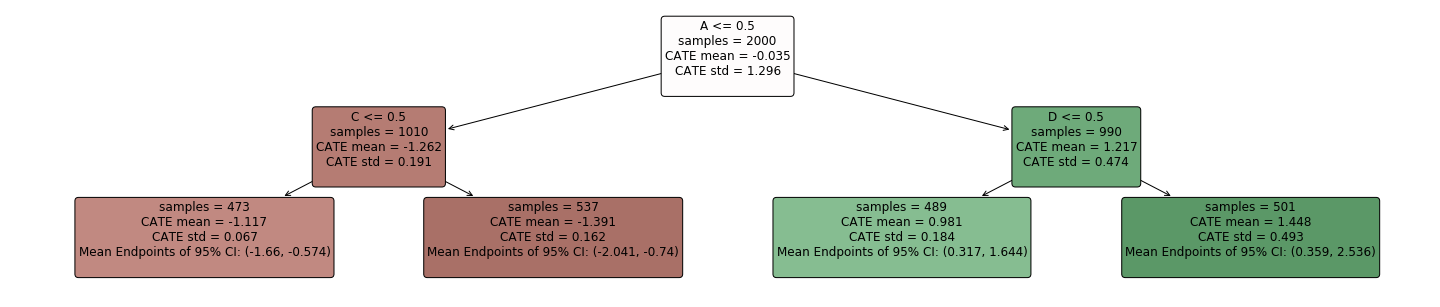

In [23]:
# or we can also plot inline with matplotlib. a bit uglier
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=['A', 'B', 'C', 'D'], fontsize=12)
plt.show()

# Tree Based Treatment Policy Based on CATE Model

In [24]:
from econml.cate_interpreter import SingleTreePolicyInterpreter

In [25]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=1, min_impurity_decrease=.001)
# We find a tree based treatment policy based on the CATE model
# sample_treatment_costs is the cost of treatment. Policy will treat if effect is above this cost.
# It can also be an array that has a different cost for each sample. In case treating different segments
# has different cost.
intrp.interpret(est, X[:, :4],
                sample_treatment_costs=0.2)

In [26]:
# exporting to a dot file
intrp.export_graphviz(out_file='cate_tree.dot', feature_names=['A', 'B', 'C', 'D'])

In [27]:
# or we can directly render. Requires the graphviz python library
intrp.render(out_file='dr_policy_tree', format='pdf', view=True, feature_names=['A', 'B', 'C', 'D'])

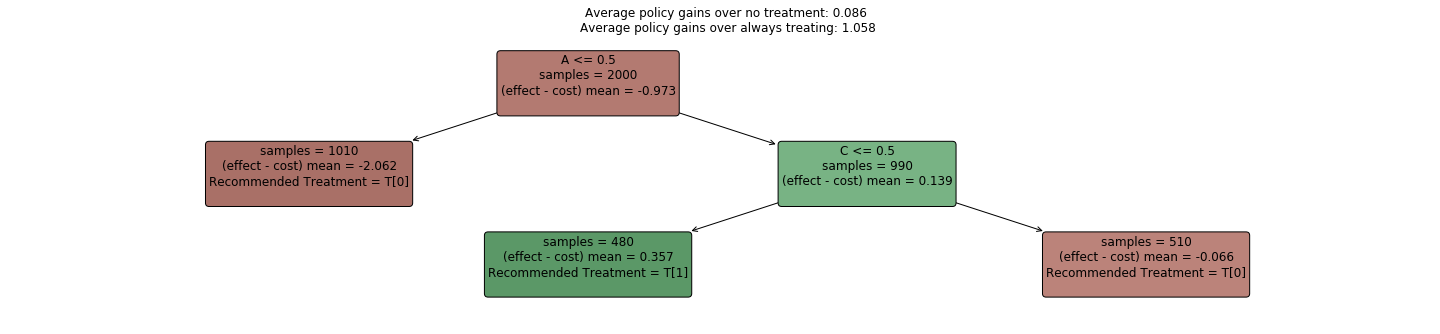

In [28]:
# or we can also plot inline with matplotlib. a bit uglier
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=['A', 'B', 'C', 'D'], fontsize=12)
plt.show()

# Non-Linear CATE Models and Bootstrap Inference

In [29]:
from econml.drlearner import DRLearner
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier

# For non-linear final models we need to use DRLearner not LinearDRLearner
est = DRLearner(model_regression=GradientBoostingRegressor(),
                model_propensity=DummyClassifier(strategy='prior'),
                model_final=GradientBoostingRegressor(min_samples_leaf=40))
est.fit(y, T, X=X[:, :4], W=X[:, 4:])

In [30]:
est.score_

10.323900331193038

### Bootstrap Inference

In [31]:
# We can also do bootstrap based inference of arbitrary models. Can be invalid
# if the final model is not well behaved and does not satisfy the regularities required
# by bootstrap inference.
from econml.drlearner import DRLearner
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier

# One can replace model_y and model_t with any scikit-learn regressor and classifier correspondingly
# as long as it accepts the sample_weight keyword argument at fit time.
est = DRLearner(model_regression=GradientBoostingRegressor(max_depth=3, n_estimators=100, min_samples_leaf=30),
                model_propensity=GradientBoostingClassifier(max_depth=3, n_estimators=100, min_samples_leaf=30),
                model_final=RandomForestRegressor(max_depth=3, n_estimators=100, min_samples_leaf=30))
est.fit(y, T, X=X[:, :4], W=X[:, 4:], inference='bootstrap')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished


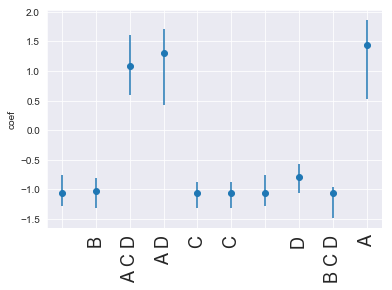

In [32]:
# Getting the confidence intervals of CATE predictions at target X's
# together with the corresponding names of the feature vectors.
feat_names = np.array(est.cate_feature_names(['A', 'B', 'C', 'D']))
X_test = np.random.binomial(1, .5, size=(10, 4))
x_names = np.array([" ".join(feat_names[x==1].astype(str)) for x in X_test])
point = est.effect(X_test)
lower, upper = np.array(est.effect_interval(X_test))
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,1) 
    x = np.arange(len(point))
    plt.errorbar(x, point, yerr, fmt='o')
    ax.set_xticks(x)
    ax.set_xticklabels(x_names, rotation='vertical', fontsize=18)
    ax.set_ylabel('coef')
    plt.show()

# SHAP Interpretability with Final Tree CATE Model

In [33]:
# We need to use a scikit-learn final model
from econml.drlearner import DRLearner
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier

# One can replace model_y and model_t with any scikit-learn regressor and classifier correspondingly
# as long as it accepts the sample_weight keyword argument at fit time.
est = DRLearner(model_regression=GradientBoostingRegressor(max_depth=3, n_estimators=100, min_samples_leaf=30),
                model_propensity=GradientBoostingClassifier(max_depth=3, n_estimators=100, min_samples_leaf=30),
                model_final=RandomForestRegressor(max_depth=3, n_estimators=100, min_samples_leaf=30))
est.fit(y, T, X=X[:, :4], W=X[:, 4:])

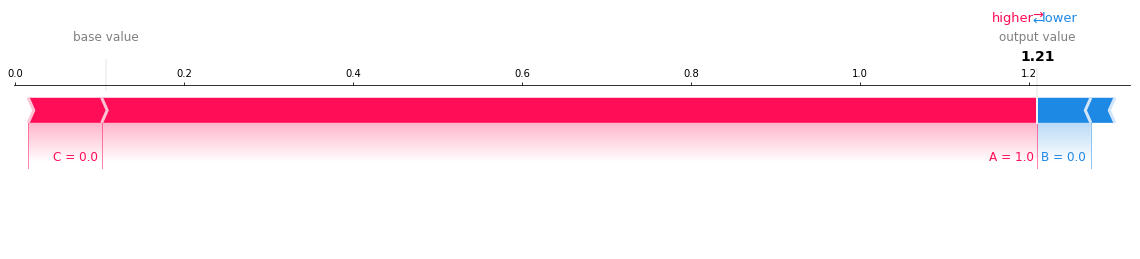

In [34]:
import shap
import pandas as pd

Xdf = pd.DataFrame(X[:, :4], columns=['A', 'B', 'C', 'D'])
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(est.model_cate(T=1))
shap_values = explainer.shap_values(Xdf)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], Xdf.iloc[0,:], matplotlib=True)

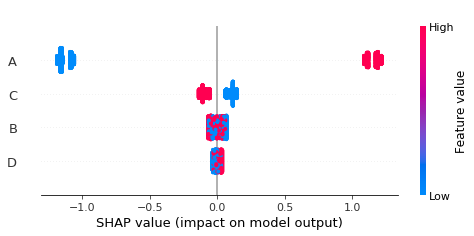

In [35]:
shap.summary_plot(shap_values, Xdf)